In [1]:
import sys
sys.path.append('/kaggle/input/alexnet/pytorch/baseline/1')
import torch
import torch.nn as nn
from torchvision import datasets
from baseline.model import AlexNetBaseline, init_params
from baseline.data_transforms import prepreprocess, get_preprocess, get_train_augment
from baseline.train import train
import matplotlib.pyplot as plt
from baseline.eval import top1_k 

In [2]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
train_dataset = datasets.Imagenette(
    'datasets/imagenette', split='train', size='320px', download=True, transform=prepreprocess)
preprocess = get_preprocess(train_dataset)

train_dataset = datasets.Imagenette(
    'datasets/imagenette', split='train', size='320px', transform=preprocess)
train_augment = get_train_augment(train_dataset, preprocess)

train_dataset = datasets.Imagenette(
    'datasets/imagenette', split='train', size='320px', transform=train_augment)

val_dataset = datasets.Imagenette(
    'datasets/imagenette', split='val', size='320px',transform=preprocess)
val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [0.5, 0.5])

print(f'Train: {len(train_dataset)}')
print(f'Validation: {len(val_dataset)}')
print(f'Test: {len(test_dataset)}')

100%|██████████| 341663724/341663724 [00:05<00:00, 57235656.38it/s]
Extracting datasets/imagenette/imagenette2-320.tgz to datasets/imagenette
Mean: [119.00183868408203, 116.9910659790039, 109.69749450683594]
Covar:
tensor([[5102.0781, 4551.8145, 4207.4111],
        [4551.8145, 4960.1279, 4866.2661],
        [4207.4111, 4866.2661, 5780.0615]])
Eigen values (sqrt):
tensor([[ 15.6196],
        [ 34.9483],
        [119.9038]])
Eigen vectors:
tensor([[ 0.4193, -0.7184, -0.5550],
        [-0.8158, -0.0299, -0.5776],
        [ 0.3984,  0.6950, -0.5986]])
Train: 9469
Validation: 1963
Test: 1962


In [4]:
model = AlexNetBaseline(len(train_dataset.classes))
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
    model = nn.DataParallel(model)
model.to(device)
# initialize parameters
init_params(model)
compiled_model = model
# if torch.cuda.is_available():
#     compiled_model = torch.compile(model)

In [5]:
costs, val_error_rates, learning_rates = train(
    compiled_model,
    train_dataset=train_dataset,
    cv_dataset=val_dataset,
    batch_size=128,
    num_epochs=200,
    initial_lr=0.01,
    num_workers=3
)

Epoch 1/200, Cost: 2.3125381, CV_Error: 90.22%, lr: 0.01, Time: 34s
Epoch 2/200, Cost: 2.3037463, CV_Error: 90.27%, lr: 0.01, Time: 35s
Epoch 3/200, Cost: 2.3020736, CV_Error: 90.27%, lr: 0.01, Time: 33s
Epoch 4/200, Cost: 2.2999391, CV_Error: 87.06%, lr: 0.01, Time: 35s
Epoch 5/200, Cost: 2.2879239, CV_Error: 87.77%, lr: 0.01, Time: 34s
Epoch 6/200, Cost: 2.2548936, CV_Error: 83.70%, lr: 0.01, Time: 34s
Epoch 7/200, Cost: 2.1856481, CV_Error: 79.37%, lr: 0.01, Time: 34s
Epoch 8/200, Cost: 2.1057905, CV_Error: 79.22%, lr: 0.01, Time: 34s
Epoch 9/200, Cost: 2.0159132, CV_Error: 81.46%, lr: 0.01, Time: 34s
Epoch 10/200, Cost: 1.8882560, CV_Error: 77.74%, lr: 0.01, Time: 34s
Epoch 11/200, Cost: 1.7569191, CV_Error: 72.29%, lr: 0.01, Time: 32s
Epoch 12/200, Cost: 1.5829008, CV_Error: 63.12%, lr: 0.01, Time: 33s
Epoch 13/200, Cost: 1.5781820, CV_Error: 69.38%, lr: 0.01, Time: 33s
Epoch 14/200, Cost: 1.4549547, CV_Error: 73.97%, lr: 0.01, Time: 33s
Epoch 15/200, Cost: 1.3495400, CV_Error: 65

In [6]:
torch.save(model.state_dict(), 'baseline_imagenette.model.pt')
torch.save(preprocess, 'baseline_imagenette.preprocess.pt')
torch.save(train_augment, 'baseline_imagenette.train_augment.pt')

In [7]:
test_top1, test_top5 = top1_k(compiled_model, test_dataset, k=5)
print(f'Test Top 1: {test_top1}')
print(f'Test Top 5: {test_top5}')

val_top1, val_top5 = top1_k(compiled_model, val_dataset, k=5)
print(f'Val Top 1: {val_top1}')
print(f'Val Top 5: {val_top5}')

train_eval_dataset = datasets.Imagenette(
    'datasets/imagenette', split='train', size='320px', transform=preprocess)
train_top1, train_top5 = top1_k(compiled_model, train_eval_dataset, k=5)
print(f'Val Top 1: {train_top1}')
print(f'Val Top 5: {train_top5}')

Test Top 1: 0.6809378185524975
Test Top 5: 0.9393476044852191
Val Top 1: 0.7065715741212429
Val Top 5: 0.9490575649516046
Val Top 1: 0.7790685394445032
Val Top 5: 0.9777167599535326


Text(0.5, 1.0, 'Costs')

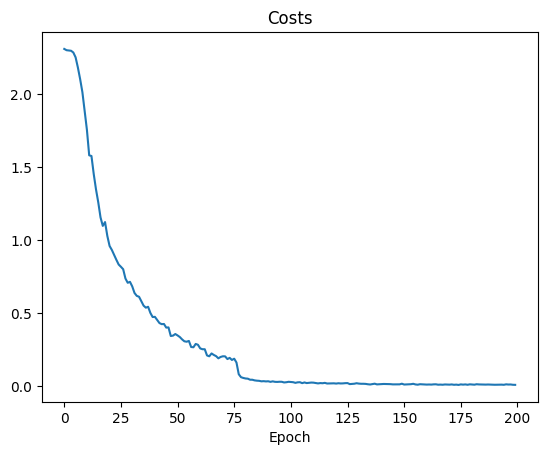

In [8]:
plt.plot(costs)
plt.xlabel("Epoch")
plt.title('Costs')

Text(0.5, 1.0, 'Cross Validation Error Rates')

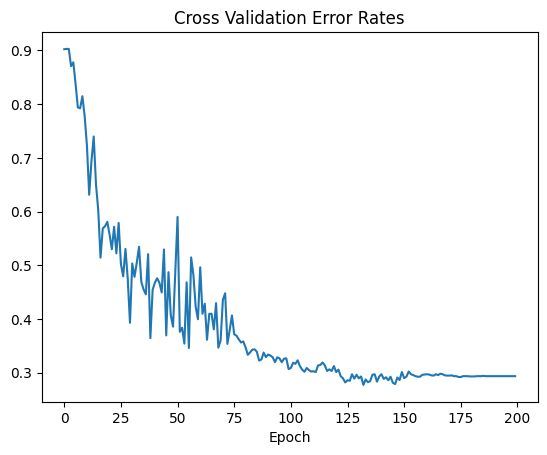

In [9]:
plt.plot(val_error_rates)
plt.xlabel("Epoch")
plt.title('Cross Validation Error Rates')

Text(0.5, 1.0, 'Learning Rates')

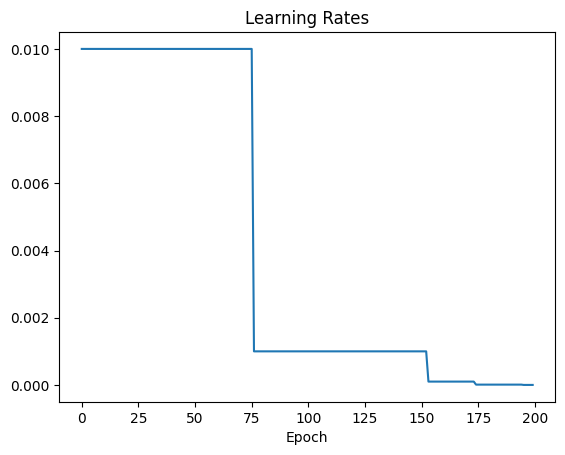

In [10]:
plt.plot(learning_rates)
plt.xlabel("Epoch")
plt.title('Learning Rates')